In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')

In [2]:
from data import RawMeanDataset, RawMean12, NatureBImproved, NatureBOriginal, TransformedMeanDataset, OmeDataset
import h5py
from data import file_path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import matplotlib
import shutil
import cv2

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


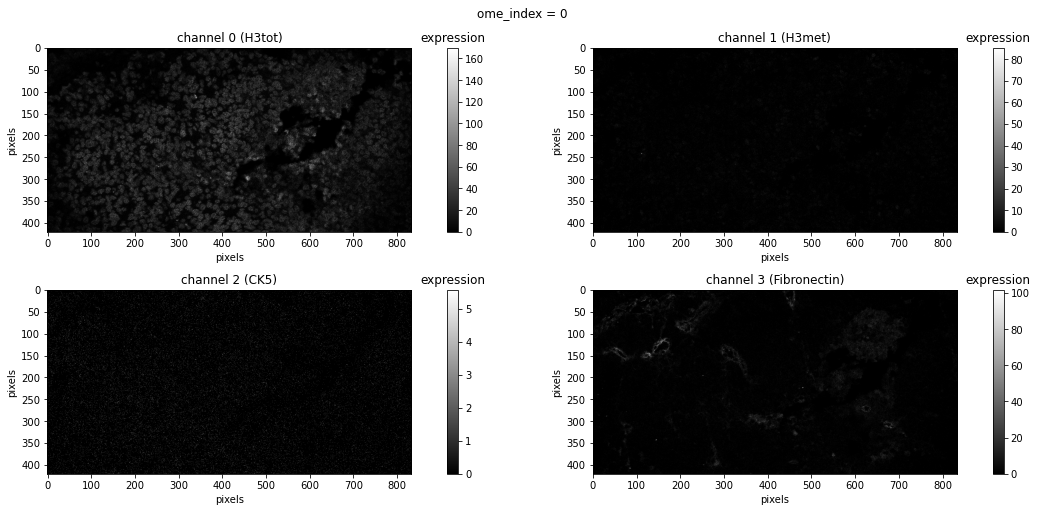

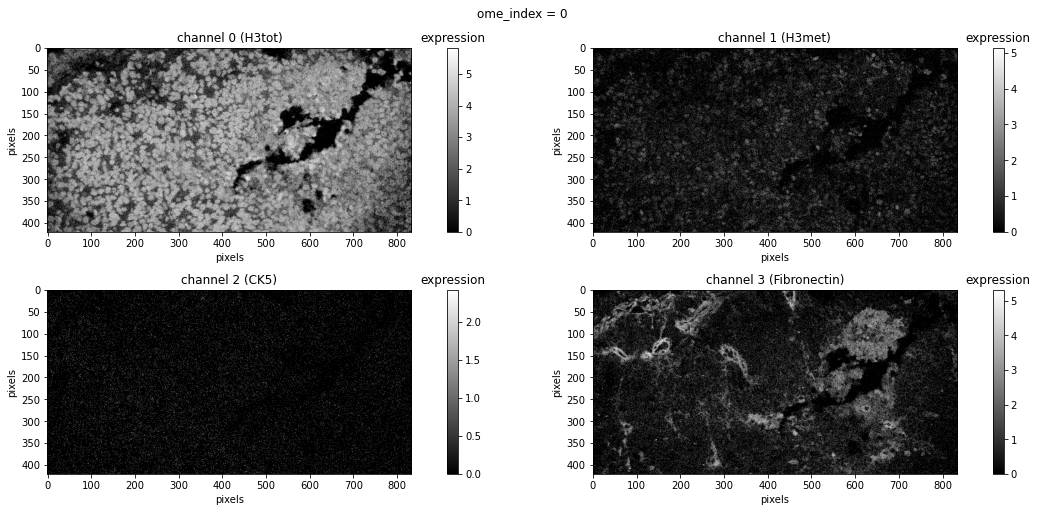

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from data import channel_names

ds = OmeDataset('train')
ome_index = 0
ds[ome_index].shape

fig, axes = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    im = ax.imshow(ds[0][:, :, i], cmap=matplotlib.cm.get_cmap('gray'))
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'channel {i} ({channel_names[i]})')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.5)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_title('expression')
plt.suptitle(f'ome_index = {ome_index}')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    im = ax.imshow(np.arcsinh(ds[0][:, :, i]), cmap=matplotlib.cm.get_cmap('gray'))
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'channel {i} ({channel_names[i]})')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.5)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_title('expression')
plt.suptitle(f'ome_index = {ome_index}')
plt.show()

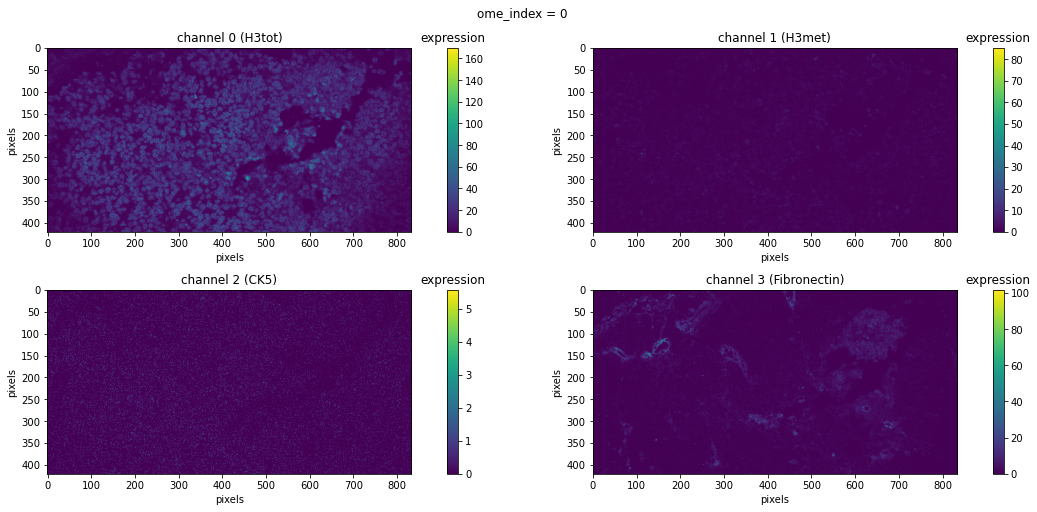

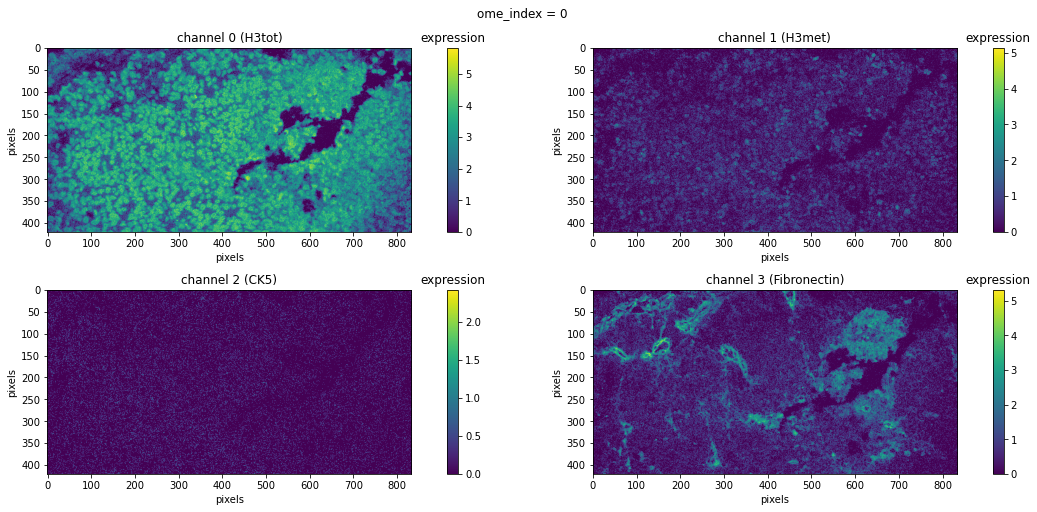

In [4]:
ds = OmeDataset('train')
ds[0].shape

fig, axes = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    im = ax.imshow(ds[0][:, :, i], cmap=matplotlib.cm.get_cmap('viridis'))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.5)
    cbar = fig.colorbar(im, cax=cax)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'channel {i} ({channel_names[i]})')
    cbar.ax.set_title('expression')
plt.suptitle(f'ome_index = {ome_index}')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    im = ax.imshow(np.arcsinh(ds[0][:, :, i]), cmap=matplotlib.cm.get_cmap('viridis'))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.5)
    cbar = fig.colorbar(im, cax=cax)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'channel {i} ({channel_names[i]})')
    cbar.ax.set_title('expression')
plt.suptitle(f'ome_index = {ome_index}')
plt.show()

In [5]:
import torch

def get_filtered_labels_mapping(ome_index, ome_filename, split):
    import pickle
    f = os.path.join('data/spatial_uzh_processed/a', f'ok_cells_{split}.npy')
    d = pickle.load(open(f, 'rb'))
    list_of_cells = d['list_of_cells']
    list_of_ome_filenames = d['list_of_ome_filenames']
    list_of_ome_indices = d['list_of_ome_indices']
    list_of_cell_ids = d['list_of_cell_ids']
    cell_is_ok = d['cell_is_ok']
    begin = list_of_ome_filenames.index(ome_filename)
    end = len(list_of_ome_filenames) - list_of_ome_filenames[::-1].index(ome_filename)
    # print(list_of_ome_filenames[begin])
    # print(list_of_ome_filenames[end - 1])
    # print(list_of_ome_filenames[end])
    # print(list_of_ome_filenames[end + 1])
    oks = cell_is_ok[begin: end]
    # labels = list_of_cell_ids[begin: end]
    # print(oks.shape)
    # print(t.shape)
    l0 = np.array(list(range(np.sum(oks).item())))
    l1 = list_of_cell_ids[ome_index][oks]
    assert len(l0) == len(l1)
    d = dict(zip(l0, l1))
    return d

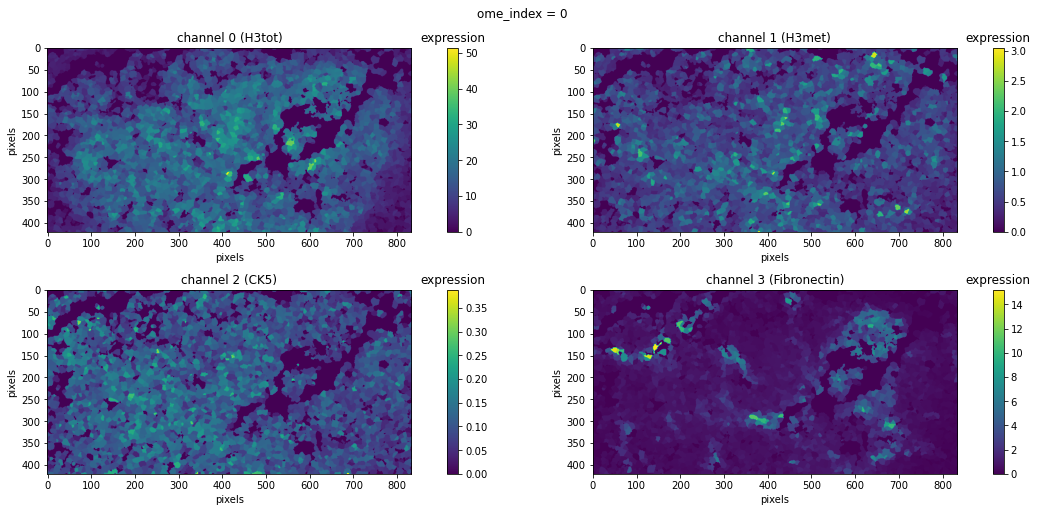

In [6]:
import math
from data import MasksDataset

ome_index = 0
ds = RawMeanDataset('train')
masks_ds_train = MasksDataset('train')

fig, axes = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    ome_filename = masks_ds_train.filenames[ome_index]
    masks = masks_ds_train[ome_index]
    d = get_filtered_labels_mapping(ome_index, ome_filename, 'train')
    e = ds[ome_index]
    c = e[:, i]
    
    new_masks = np.ones((masks.shape[0], masks.shape[1], 1))  #4))
    omitted_labels = set(list(range(np.max(masks)))).difference([dd.item() for dd in d.values()]).difference({0})
    for l in omitted_labels:
        new_masks[masks == l, :] = 0.  #(0., 0., 0., 1.)
    new_masks[masks == 0, :] = 0.  #(0., 0., 0., 1.)
    for k, v in d.items():
        new_masks[masks == v.item(), :] = c[k]  #random_colors[p[begin: end][k]]
    im = ax.imshow(new_masks, cmap=matplotlib.cm.get_cmap('viridis'))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.5)
    cbar = fig.colorbar(im, cax=cax)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'channel {i} ({channel_names[i]})')
    cbar.ax.set_title('expression')
plt.suptitle(f'ome_index = {ome_index}')
plt.show()

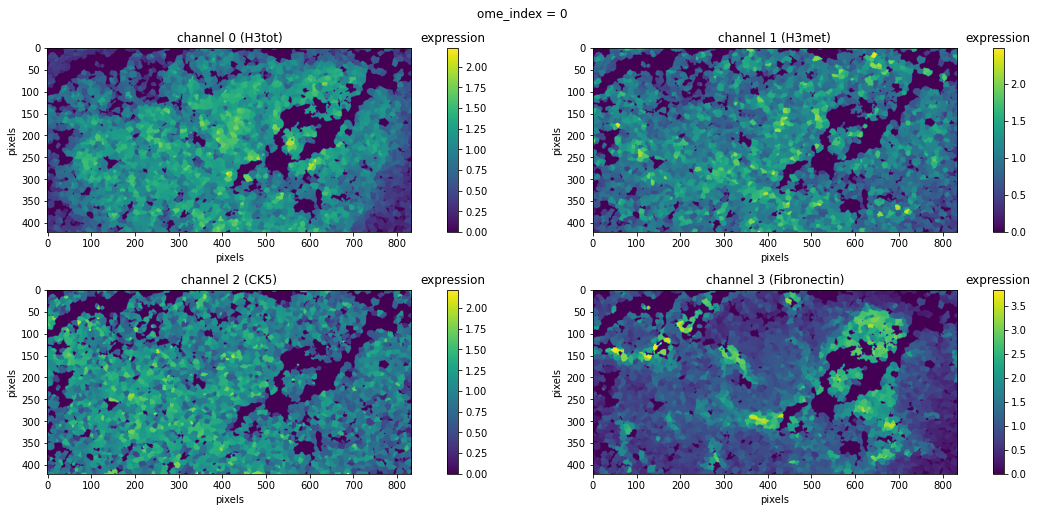

In [7]:
import math
from data import MasksDataset

ome_index = 0
ds = TransformedMeanDataset('train')
masks_ds_train = MasksDataset('train')

fig, axes = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    ome_filename = masks_ds_train.filenames[ome_index]
    masks = masks_ds_train[ome_index]
    d = get_filtered_labels_mapping(ome_index, ome_filename, 'train')
    e = ds[ome_index]
    c = e[:, i]
    
    new_masks = np.ones((masks.shape[0], masks.shape[1], 1))  #4))
    omitted_labels = set(list(range(np.max(masks)))).difference([dd.item() for dd in d.values()]).difference({0})
    for l in omitted_labels:
        new_masks[masks == l, :] = 0.  #(0., 0., 0., 1.)
    new_masks[masks == 0, :] = 0.  #(0., 0., 0., 1.)
    for k, v in d.items():
        new_masks[masks == v.item(), :] = c[k]  #random_colors[p[begin: end][k]]
    im = ax.imshow(new_masks, cmap=matplotlib.cm.get_cmap('viridis'))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.5)
    cbar = fig.colorbar(im, cax=cax)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'channel {i} ({channel_names[i]})')
    cbar.ax.set_title('expression')
plt.suptitle(f'ome_index = {ome_index}')
plt.show()

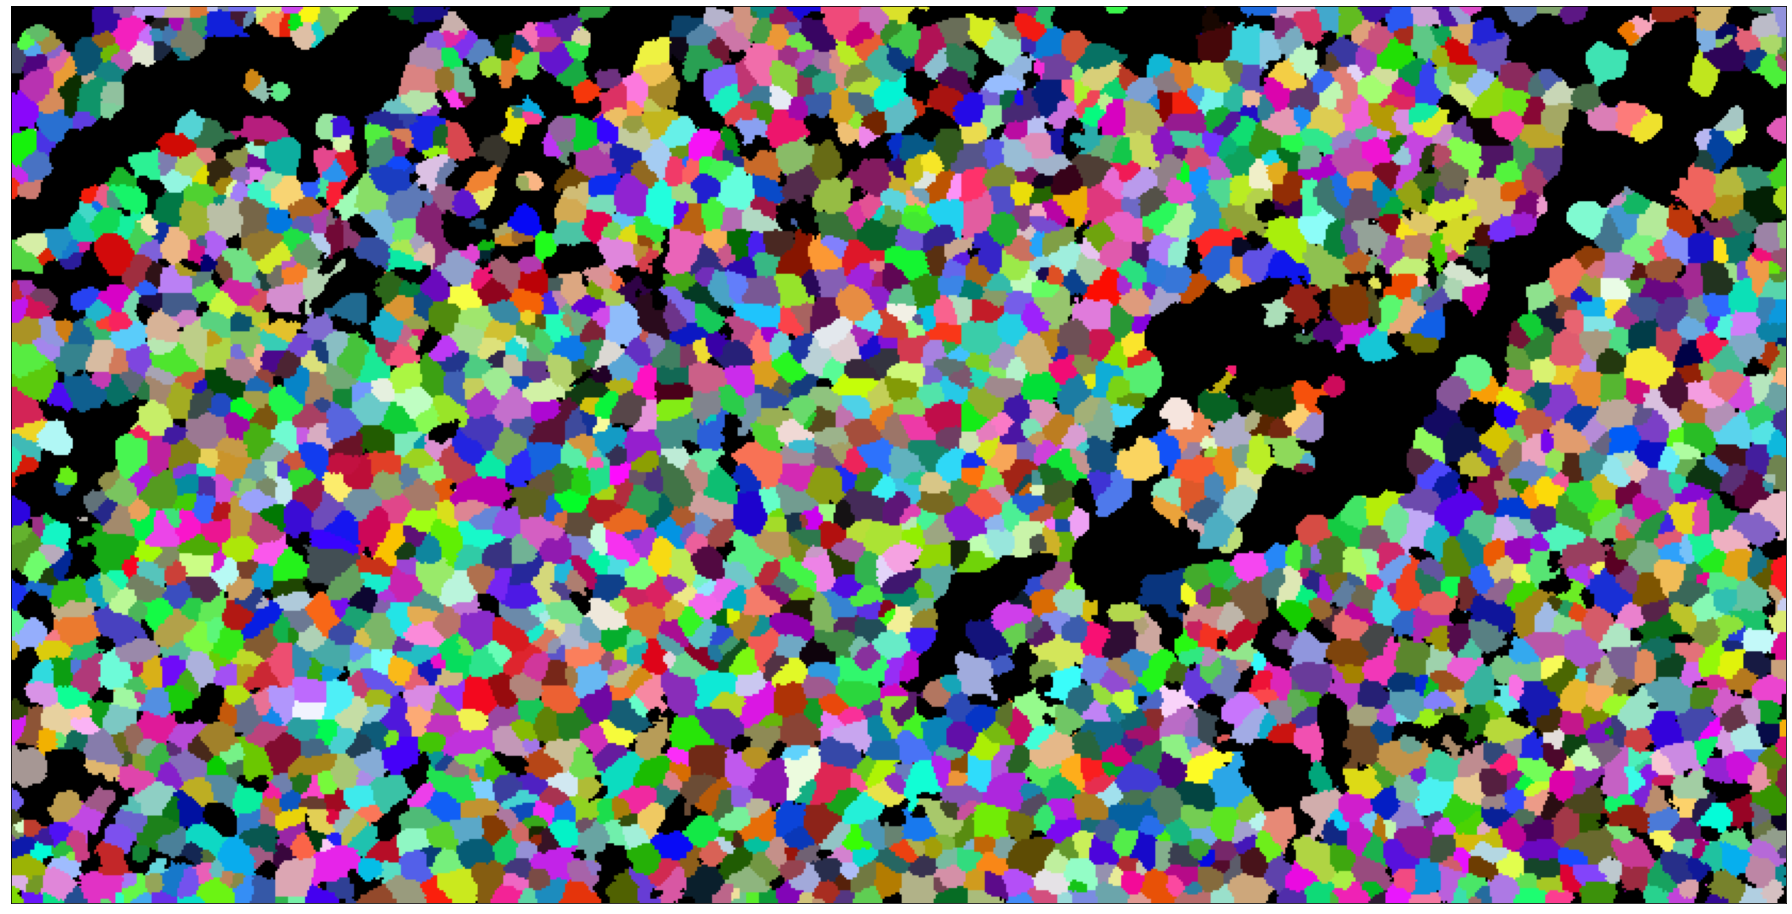

In [11]:
random_colors = np.random.rand(10000, 3)
random_colors[0, :] = 0.
alpha = 1  #0.25
masks = masks_ds_train[0]
m = np.zeros((masks.shape[0], masks.shape[1], 4))
m[:, :, 3] = alpha
m[:, :, :3] = random_colors[masks]
fig = plt.figure(figsize=(25, 18))
ax = plt.gca()
ax.patch.set_alpha(alpha)
# ax.set_xticks([])
# ax.set_yticks([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.patch.set_alpha(alpha)
plt.imshow(m)
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.tight_layout(rect=[0.0, 0.0, 1.0, 1.0])
plt.savefig('/data/l989o/a/masks.png', bbox_inches='tight', pad_inches=0)
plt.show()

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


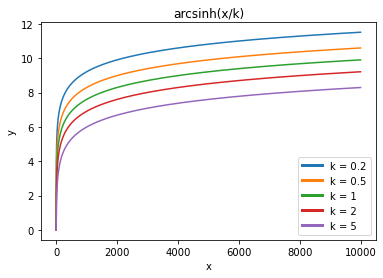

In [9]:
from matplotlib.lines import Line2D

color_cycler = plt.rcParams['axes.prop_cycle']
colors = [d['color'] for d in color_cycler._left]
print(colors)
plt.figure()
x = np.linspace(0, 10000, 10000)
labels = []
for k in [0.2, 0.5, 1, 2, 5]:
    y = np.arcsinh(x / k)  #/ np.log(x)
    plt.plot(x, y)
    labels.append(f'k = {k}')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
plt.legend(lines, labels)
plt.title('arcsinh(x/k)')
plt.xlabel('x')
plt.ylabel('y')
# plt.yscale('log')
plt.show()

Text(0, 0.5, 'channels')

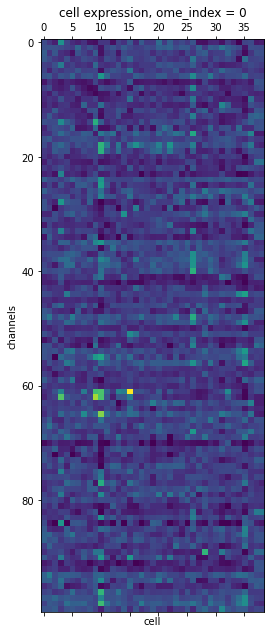

In [10]:
ds = TransformedMeanDataset('train')
x = ds[0].numpy()
y = np.random.choice(len(x), 100)
z = x[y, :]
plt.matshow(z)
plt.title('cell expression, ome_index = 0')
plt.xlabel('cell')
plt.ylabel('channels')

In [2]:
from data import RawMeanDataset
len(RawMeanDataset('validation'))

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


113